In [1]:
path = "/home/hexart/dataset/aptos2019-blindness-detection/"

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
df = pd.read_csv(os.path.join(path,"train.csv"))

In [4]:
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
df.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [6]:
def get_sample(dataset:str) -> np.ndarray:
    """
    This function will sample unbalanced dr_dataset into a balanced dr_dataset
    ***FOR DIABETIC RETINPATHY ONLY***
    :param dataset: csv file of the dr_dataset
    :return: numpy array containing shuffled balanced data samples
    """

    df_data = pd.read_csv(dataset)
    df_data_classes = dict.fromkeys(pd.unique(df_data.diagnosis))
    for i in pd.unique(df_data.diagnosis):
        df_data_classes[i] = df_data[df_data.diagnosis == i]


    n = np.min((df_data_classes[0].shape[0],
                df_data_classes[1].shape[0],
                df_data_classes[2].shape[0],
                df_data_classes[3].shape[0],
                df_data_classes[4].shape[0],))

    n = int(n - (n//4))

    rng = np.random.default_rng()
    train_samples = np.concatenate((rng.permutation(df_data_classes[0])[:n],
                                   rng.permutation(df_data_classes[1])[:n],
                                   rng.permutation(df_data_classes[2])[:n],
                                   rng.permutation(df_data_classes[3])[:n],
                                   rng.permutation(df_data_classes[4])[:n],))

    random_training_samples = rng.permutation(train_samples)

    return random_training_samples

In [7]:
data = get_sample(os.path.join(path,"train.csv"))

In [8]:
data.shape[0]/5

145.0

In [9]:
training_set = data[:int(len(data)*0.8)]
testing_set = data[int(len(data) * 0.8):]

In [10]:
import torch

In [11]:
torch.cuda.is_available()

True

In [12]:
image_dataset = dict.fromkeys(['train','val'])

In [13]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class dr_dataset(Dataset):

    def __init__(self, numpy_array, data_dir, transform=None, target_transform=None, ext=".png"):
        self.img_labels = pd.DataFrame(numpy_array)
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.ext = ext



    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, item):
        img_path = os.path.join(self.data_dir,self.img_labels.iloc[item,0]+self.ext)
        img = Image.open(img_path)
        label = self.img_labels.iloc[item,1]
        if self.transform:
            img = self.transform(img)
        else:
            self.transform = transforms.Compose([
                transforms.Resize(255),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225]),
            ])
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)

        return (img, label,)

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [15]:
image_dataset['train'] = dr_dataset(numpy_array=training_set,
                                     data_dir=os.path.join(path,'train_images'),
                                     transform = data_transforms['train'])
image_dataset['val'] = dr_dataset(numpy_array=testing_set,
                                     data_dir=os.path.join(path,'train_images'),
                                     transform = data_transforms['val'])

In [16]:
from torch.utils.data import DataLoader

dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x],
                                              batch_size=12,
                                              shuffle=True,
                                              num_workers=2)
               for x in ['train','val']}

In [17]:
dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'val']}


class_names = {
    0 : "No DR",
    1 : "NPDR Mild",
    2 : "NPDR Moderate",
    3 : "NPDR Severe",
    4 : "PDR"
}


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [19]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import time
from sklearn.metrics import cohen_kappa_score



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    metrics = []
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        predictions = []
        ground_truth = []

        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                predictions.extend(preds.cpu().detach().numpy())
                ground_truth.extend(labels.cpu().detach().numpy())

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_kappa = cohen_kappa_score(predictions, ground_truth)
            print('{} Loss:\t{:.4f}\tAcc:\t{:.4f}\tKappa:\t{:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_kappa))
            metrics.append([epoch,
                            phase,
                            epoch_loss,
                            epoch_acc.cpu().detach().numpy(),
                            epoch_kappa])

    time_elapsed = time.time() - since
    print("Training Completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

    return (model,metrics,predictions, ground_truth)

In [20]:
#model_ft = models.resnet152(pretrained=True)
#num_ftrs = model_ft.fc.in_features
model_ft = models.densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 5)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma=0.1)

In [21]:
model, metrics, predictions, ground_truth = train_model(model_ft,criterion,
                                                        optimizer_ft,
                                                        exp_lr_scheduler,
                                                        num_epochs=25)


Epoch 0/24
----------
train Loss:	1.4979	Acc:	0.3293	Kappa:	0.1606
val Loss:	1.3018	Acc:	0.4552	Kappa:	0.1931

Epoch 1/24
----------
train Loss:	1.2553	Acc:	0.4552	Kappa:	0.3187
val Loss:	1.0692	Acc:	0.5448	Kappa:	0.3414

Epoch 2/24
----------
train Loss:	1.1036	Acc:	0.5431	Kappa:	0.4286
val Loss:	1.0957	Acc:	0.5931	Kappa:	0.4414

Epoch 3/24
----------
train Loss:	1.0597	Acc:	0.5810	Kappa:	0.4763
val Loss:	1.1841	Acc:	0.5379	Kappa:	0.4655

Epoch 4/24
----------
train Loss:	1.0033	Acc:	0.6000	Kappa:	0.4995
val Loss:	0.9298	Acc:	0.6138	Kappa:	0.5034

Epoch 5/24
----------
train Loss:	0.9331	Acc:	0.6207	Kappa:	0.5256
val Loss:	0.9692	Acc:	0.6069	Kappa:	0.5224

Epoch 6/24
----------
train Loss:	0.9126	Acc:	0.6345	Kappa:	0.5432
val Loss:	1.0158	Acc:	0.5655	Kappa:	0.5259

Epoch 7/24
----------
train Loss:	0.8324	Acc:	0.6879	Kappa:	0.6096
val Loss:	0.9573	Acc:	0.5862	Kappa:	0.5845

Epoch 8/24
----------
train Loss:	0.7727	Acc:	0.7069	Kappa:	0.6332
val Loss:	0.9563	Acc:	0.6138	Kappa:	0.6103



In [22]:
import matplotlib.pyplot as plt

In [23]:
df = pd.DataFrame(metrics)

In [24]:
train_metrics = df[df[1] == 'train']
val_metrics = df[df[1] == 'val']
plots = "/home/hexart/hexart/Hexart_Research_Cohort_2/Diabetic_Retinopathy/plots"

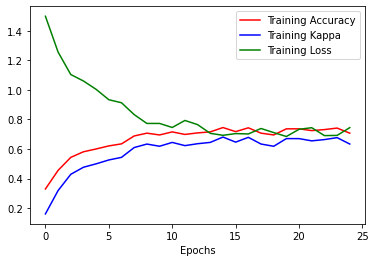

In [25]:
plt.plot(train_metrics[0],train_metrics[3],'r',label="Training Accuracy")
plt.plot(train_metrics[0],train_metrics[4],'b',label="Training Kappa")
plt.plot(train_metrics[0],train_metrics[2],'g',label="Training Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(os.path.join(plots,"dr_densenet121_pretrained_e{}_{}".format(25,'train')))

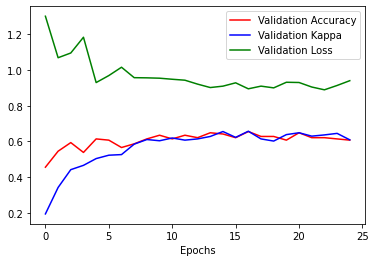

In [26]:
plt.plot(val_metrics[0],val_metrics[3],'r',label="Validation Accuracy")
plt.plot(val_metrics[0],val_metrics[4],'b',label="Validation Kappa")
plt.plot(val_metrics[0],val_metrics[2],'g',label="Validation Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(os.path.join(plots,"dr_densenet121_pretrained_e{}_{}".format(25,'val')))

In [27]:
# Untrained Resnet152
#un_model_ft = models.resnet152(pretrained=False)
#num_ftrs = un_model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 5)
un_model_ft = models.densenet121(pretrained=True)
num_ftrs = un_model_ft.classifier.in_features
un_model_ft.classifier = nn.Linear(num_ftrs, 5)
un_model_ft = un_model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(un_model_ft.parameters(), lr=0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma=0.1)

In [28]:
un_model, un_metrics, un_predictions, un_ground_truth = train_model(un_model_ft,criterion,
                                                        optimizer_ft,
                                                        exp_lr_scheduler,
                                                        num_epochs=25)


Epoch 0/24
----------
train Loss:	1.5173	Acc:	0.2948	Kappa:	0.1180
val Loss:	1.2206	Acc:	0.4966	Kappa:	0.1690

Epoch 1/24
----------
train Loss:	1.2025	Acc:	0.5172	Kappa:	0.3965
val Loss:	1.0285	Acc:	0.5241	Kappa:	0.3983

Epoch 2/24
----------
train Loss:	1.1939	Acc:	0.5052	Kappa:	0.3807
val Loss:	1.1272	Acc:	0.5241	Kappa:	0.3862

Epoch 3/24
----------
train Loss:	1.1565	Acc:	0.5224	Kappa:	0.4024
val Loss:	1.0671	Acc:	0.5241	Kappa:	0.4034

Epoch 4/24
----------
train Loss:	1.0178	Acc:	0.5724	Kappa:	0.4652
val Loss:	0.9645	Acc:	0.6138	Kappa:	0.4759

Epoch 5/24
----------
train Loss:	0.9672	Acc:	0.5948	Kappa:	0.4927
val Loss:	0.9341	Acc:	0.6069	Kappa:	0.4966

Epoch 6/24
----------
train Loss:	0.9574	Acc:	0.6138	Kappa:	0.5173
val Loss:	1.1498	Acc:	0.5655	Kappa:	0.5052

Epoch 7/24
----------
train Loss:	0.9238	Acc:	0.6138	Kappa:	0.5158
val Loss:	0.9350	Acc:	0.6069	Kappa:	0.5155

Epoch 8/24
----------
train Loss:	0.8062	Acc:	0.6793	Kappa:	0.5990
val Loss:	0.9469	Acc:	0.6000	Kappa:	0.5793



In [29]:
un_df = pd.DataFrame(un_metrics)

In [30]:
un_train_metrics = un_df[un_df[1] == 'train']
un_val_metrics = un_df[un_df[1] == 'val']
plots = "/home/hexart/hexart/Hexart_Research_Cohort_2/Diabetic_Retinopathy/plots"

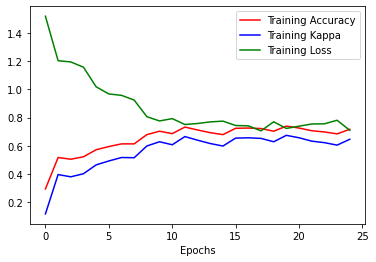

In [31]:
plt.plot(un_train_metrics[0],un_train_metrics[3],'r',label="Training Accuracy")
plt.plot(un_train_metrics[0],un_train_metrics[4],'b',label="Training Kappa")
plt.plot(un_train_metrics[0],un_train_metrics[2],'g',label="Training Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(os.path.join(plots,"dr_densenet121_untrained_e{}_{}".format(25,'train')))

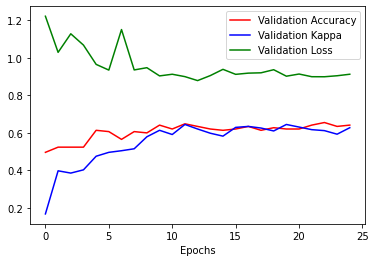

In [32]:
plt.plot(un_val_metrics[0],un_val_metrics[3],'r',label="Validation Accuracy")
plt.plot(un_val_metrics[0],un_val_metrics[4],'b',label="Validation Kappa")
plt.plot(un_val_metrics[0],un_val_metrics[2],'g',label="Validation Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(os.path.join(plots,"dr_densenet121_untrained_e{}_{}".format(25,'val')))

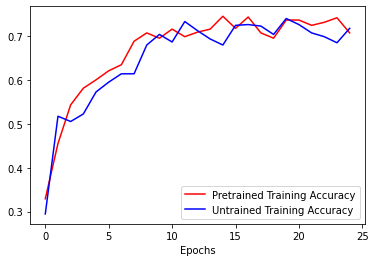

In [33]:
plt.plot(train_metrics[0],train_metrics[3],'r',label="Pretrained Training Accuracy")
plt.plot(train_metrics[0],un_train_metrics[3],'b',label="Untrained Training Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(os.path.join(plots,"dr_densenet121_accuracy_e{}_{}".format(25,'train')))

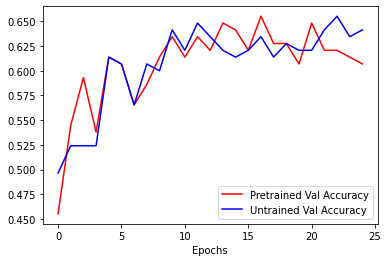

In [34]:
plt.plot(val_metrics[0],val_metrics[3],'r',label="Pretrained Val Accuracy")
plt.plot(val_metrics[0],un_val_metrics[3],'b',label="Untrained Val Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(os.path.join(plots,"dr_densenet121_accuracy_e{}_{}".format(25,'val')))

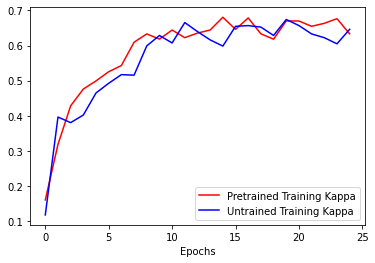

In [35]:
plt.plot(train_metrics[0],train_metrics[4],'r',label="Pretrained Training Kappa")
plt.plot(train_metrics[0],un_train_metrics[4],'b',label="Untrained Training Kappa")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(os.path.join(plots,"dr_densenet121_kappa_e{}_{}".format(25,'train')))

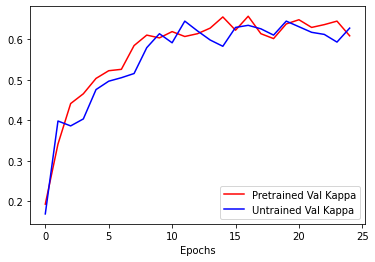

In [36]:
plt.plot(val_metrics[0],val_metrics[4],'r',label="Pretrained Val Kappa")
plt.plot(val_metrics[0],un_val_metrics[4],'b',label="Untrained Val Kappa")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(os.path.join(plots,"dr_densenet121_kappa_e{}_{}".format(25,'val')))